Predicting Home Values with Zillow
===

[[acquire](#Acquire-Data)] [[prepare](#Data-Preparation)] [[explore](#Data-Exploration)] [[model](#Modeling)] [[tax rates](#Estimating-Tax-Rates)] [[summary](#Summary)]<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;+[[ eval ](#Model-Evaluation)]<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;+[[ test ](#Model-Test)]<br>

This notebook serves to document the process of creating models and generating a report on prediction of home values using Zillow data for houses sold in three California counties during the "hot months" of May through August 2017. The document will contain headers to distinguish the creation of the minimally viable product (prediction of property assessed tax value using only counts of bedrooms, bathrooms, square footage), obtaining tax rate data for the counties in question, and further potential exploration beyond. Key findings and thoughts are documented throughout the process, and are summarized at the foot of the notebook.

## Initialize Notebook
---

In [1]:
# import from standard libraries
import pandas as pd
import numpy as np

# import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# import model creation tools
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# import module functions
from acquire import get_sql, acquire_mvp
from prepare import shed_zscore_outliers, show_distributions, prepare_mvp
from explore import explore_mvp, get_tax_rates, get_tax_rates_county, plot_heat, \
                    plot_univariate, plot_discrete_to_continous, plot_joint, corr_test
from model import minmax, select_kbest, select_rfe, get_metrics, \
                  train_model, model_testing, plot_residuals

# cosmetic settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from end import end

## Acquire Data
---

In [2]:
# SQL query for initial DataFrame grab
# joins predictions_2017 for dates to filter "hot months"
# uses propertylandusetypeid as described in propertylandusetype
# table to filter only single unit properties
query = '''
SELECT *
FROM properties_2017
INNER JOIN predictions_2017 USING(parcelid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
WHERE
    propertylandusetypeid IN (261, 263, 264, 266, 268, 275, 276, 279) AND
    CAST(transactiondate AS DATE) BETWEEN 20170501 AND 20170831
ORDER BY
    properties_2017.id ASC
;'''

In [3]:
# obtain initial DataFrame using get_sql function
df = get_sql(query, 'zillow')

In [4]:
# check DataFrame dimensions
df.shape

(38412, 63)

In [5]:
# check first row of DataFrame
df.head(1).T

0
propertylandusetypeid                         261.0
parcelid                                   17054981
id                                              349
airconditioningtypeid                           NaN
architecturalstyletypeid                        NaN
...                                             ...
censustractandblock                61110009011034.0
id                                            46824
logerror                                  -0.013099
transactiondate                          2017-06-15
propertylandusedesc       Single Family Residential

[63 rows x 1 columns]

<br>🚨 **Notice** 🚨 <br>
_Multiple `id` columns exist, we will adjust our query to distinguish these and retain the `id` from the primary table._
<br><br>

In [6]:
# due to multiple id columns, set primary table key as "property_id"
query = '''
SELECT *, properties_2017.id AS property_id
FROM properties_2017
INNER JOIN predictions_2017 USING(parcelid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
WHERE
    propertylandusetypeid IN (261, 263, 264, 266, 268, 275, 276, 279) AND
    CAST(transactiondate AS DATE) BETWEEN 20170501 AND 20170831
ORDER BY
    properties_2017.id ASC
;'''

In [7]:
# obtain DataFrame with adjusted query
df = get_sql(query, 'zillow', use_csv=False)

In [8]:
# drop id columns while retainging property_id
df = df.drop(columns=['id'])

In [9]:
# set property_id as index to avoid losing this data in scaling
# due to human error
df = df.set_index('property_id')

In [10]:
# sort columns for ease of understanding
cols = list(df)
cols.sort()
df = df[cols]

In [11]:
# check DataFrame dimensions again
df.shape

(38412, 61)

In [12]:
# check first row of newly ordered DataFrame
df.head(1).T

property_id                  349
airconditioningtypeid        NaN
architecturalstyletypeid     NaN
assessmentyear            2016.0
basementsqft                 NaN
bathroomcnt                  5.0
...                          ...
typeconstructiontypeid       NaN
unitcnt                      NaN
yardbuildingsqft17           NaN
yardbuildingsqft26           NaN
yearbuilt                 1982.0

[61 rows x 1 columns]

In [13]:
# inspect DataFrame structure, values, counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38412 entries, 349 to 2982274
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         12222 non-null  float64
 1   architecturalstyletypeid      101 non-null    float64
 2   assessmentyear                38412 non-null  float64
 3   basementsqft                  25 non-null     float64
 4   bathroomcnt                   38412 non-null  float64
 5   bedroomcnt                    38412 non-null  float64
 6   buildingclasstypeid           0 non-null      object 
 7   buildingqualitytypeid         23698 non-null  float64
 8   calculatedbathnbr             38269 non-null  float64
 9   calculatedfinishedsquarefeet  38314 non-null  float64
 10  censustractandblock           38271 non-null  float64
 11  decktypeid                    321 non-null    float64
 12  finishedfloor1squarefeet      3153 non-null   float64
 1

<br>🚨 **Notice** 🚨 <br>
_Many columns have substantial amounts of data missing. We will drop columns with more than 5% null data._<br><br>

In [14]:
# drop columns with more than 5% data missing
df = df.dropna(axis=1, thresh=36491)

In [15]:
# recheck DataFrame .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38412 entries, 349 to 2982274
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   assessmentyear                38412 non-null  float64
 1   bathroomcnt                   38412 non-null  float64
 2   bedroomcnt                    38412 non-null  float64
 3   calculatedbathnbr             38269 non-null  float64
 4   calculatedfinishedsquarefeet  38314 non-null  float64
 5   censustractandblock           38271 non-null  float64
 6   finishedsquarefeet12          38200 non-null  float64
 7   fips                          38412 non-null  float64
 8   fullbathcnt                   38269 non-null  float64
 9   landtaxvaluedollarcnt         38411 non-null  float64
 10  latitude                      38412 non-null  float64
 11  logerror                      38412 non-null  float64
 12  longitude                     38412 non-null  float64
 1

### Initial Thoughts

Most of our initial columns were unusable due to significant missing data. Of the $38,412$ rows returned, some columns had null values for as much as $99\%$ of them. Our requisite variables for the minimally viable product, as well as our target, have sufficient usable data for our purposes. 

**Variables**:
- `calculatedfinishedsquarefeet`, 38314 _non-null_ values, dtype $=$ float64
- `bedroomcnt`, 38412 _non-null_ values, dtype $=$ float64
- `bathroomcnt`, 38412 _non-null_ values, dtype $=$  float64

**Target**:
- `taxvaluedollarcnt`, 38411 _non-null_ values, dtype $=$ float64

There is also sufficient data to obtain tax rates for counties in which the properties exist.

- `fips`, 38412 _non-null_ values, dtype $=$ float64
    - can be used with data from [census.gov](https://www.census.gov/prod/techdoc/cbp/95-96cd/fips-st.pdf) to establish county
- `taxamount`, 38411 _non-null_ values, dtype $=$ float64
    -  can be used in with `taxvaluedollarcnt` to obtain an estimated tax rate

**Takeaways**

Of our returned $38,412$ rows, the requisite variable that is missing the most data is `calculatedfinishedsquarefeet` with $98$ null values. This represents $\approx0.001\%$ of our data, and can be safely dropped without significant alarm. With enough time, we can explore additional variables for model creation. For now, we will move on with creating our minimally viable product.

**Starting Hypotheses**

- H$_0$: _Assessed property value does not increase with square feet of the structure._
- H$_a$: _Assessed property value increases with square feet of the structure._

It seems likely that as the dimensions of the property increase, that the value of the property would increase linearly with it.

In [16]:
# use created function to perform prep work established in above cells
df_mvp = acquire_mvp()

[[return to top](#Predicting-Home-Values-with-Zillow)]

## Data Preparation
### Minimally Viable Product

In [17]:
# check DataFrame dimensions
df_mvp.shape

(38312, 6)

In [18]:
# inspect first row of DataFrame
df_mvp.head(1).T

property_id           349
bedrooms             4.00
bathrooms            5.00
fips              6111.00
square_feet       3760.00
tax_amount_usd    9673.46
tax_value_usd   872850.00

In [19]:
# view DataFrame structure, values, counts, and data types
df_mvp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38312 entries, 349 to 2982274
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        38312 non-null  float64
 1   bathrooms       38312 non-null  float64
 2   fips            38312 non-null  float64
 3   square_feet     38312 non-null  float64
 4   tax_amount_usd  38312 non-null  float64
 5   tax_value_usd   38312 non-null  float64
dtypes: float64(6)
memory usage: 2.0 MB


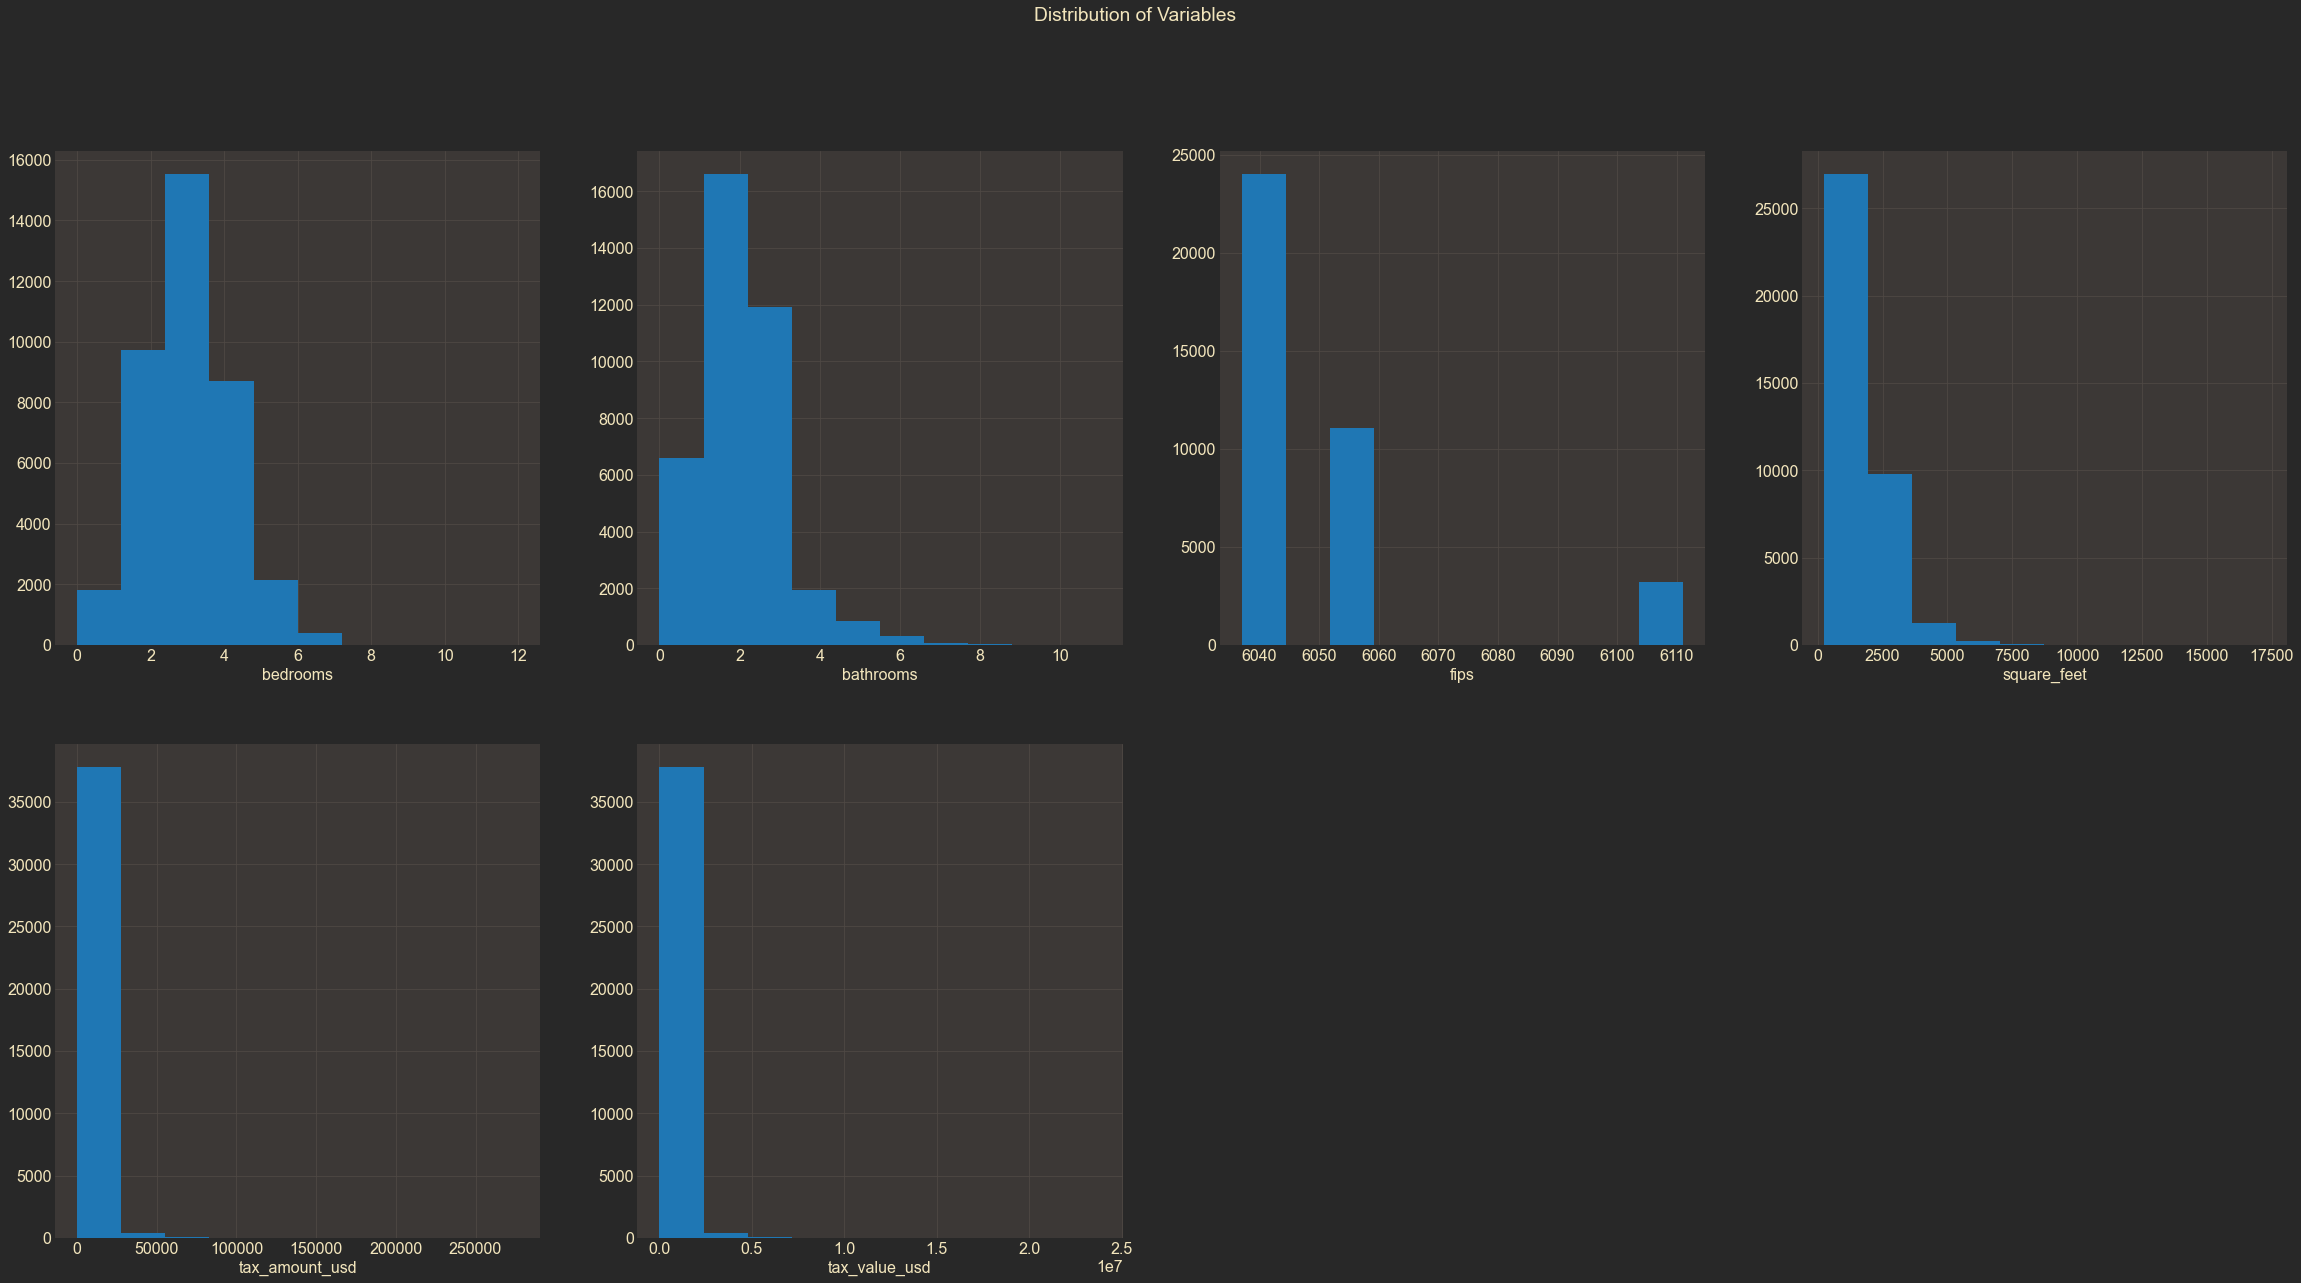

In [20]:
# visualize the MVP variables
show_distributions(df_mvp)

#### Data Impressions

Looking at the distributions, we can see some heavy right skews in `square_feet`, `tax_amount_usd`, `and tax_value_usd`. This can cause some problems down the line when scaling data for modeling, and it is best to remove some of the egregious outliers. We will create a function that can safely remove outliers, but allow us to exclude values that should not be pruned, like `fips`.

#### Handling Outliers
##### Using Z-Score

Here we have created a function that will remove all values that are $\pm$ 3 standard deviations from the mean. We will again visualize our variables to check the results.

In [21]:
# check dimensions before removing outliers
df_mvp.shape

(38312, 6)

In [22]:
# check dimensions for comparison after removal
df_mvp = shed_zscore_outliers(df_mvp, 'fips')

In [23]:
df_mvp.shape

(37249, 6)

In [24]:
# visualize the new distributions
show_distributions(df_mvp)

<br>We can see there is still some right skew in the three variables mentioned before, but it has reduced quite significantly. This should improve the results of our scaled data being passed into our models later on. We see there are some properties that do not have a bathroom or a bedroom. This is unlikely to be the case for the single unit properties we are looking at, and is likely the result of missing data or improper labels. We will also drop these few rows to avoid using inappropriate data.<br><br>

In [25]:
# remove 0 values from bedrooms and bathrooms
df_mvp = df_mvp.loc[((df_mvp.bedrooms != 0) & (df_mvp.bathrooms != 0))]

In [26]:
# check shape to see remaining data
df_mvp.shape

(37091, 6)

In [27]:
# inspect values have been removed
df_mvp.bathrooms.unique()

array([5. , 2. , 1.5, 1. , 2.5, 3. , 4.5, 4. , 3.5])

In [28]:
# inspect values have been removed
df_mvp.bedrooms.unique()

array([4., 3., 2., 5., 1., 6.])

<br>Now that we have removed our inappropriate data, the last thing to do is replace our `fips`, or Federal Information Processing Standards codes, with human readable county names. These names are taken directly from the [cenusus.gov](https://www.census.gov/prod/techdoc/cbp/95-96cd/fips-st.pdf) website. All of the values within the `fips` column correspond to counties in the US state of California. We will use this data to calculate estimated tax rates for the counties in which these properties exist.<br><br>

In [29]:
# output fips values
df_mvp.fips.unique()

array([6111., 6037., 6059.])

In [30]:
# replace fips numerical codes with string county names and rename column
df_mvp.fips = np.where(df_mvp.fips == 6037.0, 'Los Angeles', df_mvp.fips)
df_mvp.fips = np.where(df_mvp.fips == '6059.0', 'Orange', df_mvp.fips)
df_mvp.fips = np.where(df_mvp.fips == '6111.0', 'Ventura', df_mvp.fips)
df_mvp = df_mvp.rename(columns=({'fips':'county'}))

In [31]:
# inspect first row
df_mvp.head(1).T

property_id          349
bedrooms             4.0
bathrooms            5.0
county           Ventura
square_feet       3760.0
tax_amount_usd   9673.46
tax_value_usd   872850.0

In [32]:
# inspect unique county values
df_mvp.county.unique()

array(['Ventura', 'Los Angeles', 'Orange'], dtype=object)

#### Finalize Preparation

Now that these values are filled with something human readable, we can also encode this data to better use in machine learning. These will not be used in our MVP, but can be utilized in further modeling.

In [33]:
# reassign DataFrame to hold new encoded colummns
df_mvp = pd.get_dummies(df_mvp, columns=['county'], drop_first=True)

In [34]:
# check shape for new row
df_mvp.shape

(37091, 7)

In [35]:
# inspect first row
df_mvp.head(1).T

property_id           349
bedrooms             4.00
bathrooms            5.00
square_feet       3760.00
tax_amount_usd    9673.46
tax_value_usd   872850.00
county_Orange        0.00
county_Ventura       1.00

Having completed this portion of data preparation and obtaining the requested county tax rates, we can move on to exploring our data for our minimally viable product. First we will create a function to obtain all our data as needed for our MVP to split into `train`, `validate`, and `test` datasets.

[[return to top](#Predicting-Home-Values-with-Zillow)]

## Data Exploration
### Minimally Viable Product

In [36]:
# test split_data function on prepare_mvp and return explore
# DataFrame and X, y for train, validate, and test
df_mvp, \
X_train_mvp, y_train_mvp, \
X_validate_mvp, y_validate_mvp, \
X_test_mvp, y_test_mvp = explore_mvp()

In [37]:
# check dimensions of explore and X DataFrames
df_mvp.shape, X_train_mvp.shape, X_validate_mvp.shape, X_test_mvp.shape

((22254, 4), (22254, 3), (7418, 3), (7419, 3))

In [38]:
# check info to ensure DataFrame is read in appropriately
df_mvp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22254 entries, 174360 to 612638
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       22254 non-null  float64
 1   bathrooms      22254 non-null  float64
 2   square_feet    22254 non-null  float64
 3   tax_value_usd  22254 non-null  float64
dtypes: float64(4)
memory usage: 869.3 KB


#### Visual Exploration

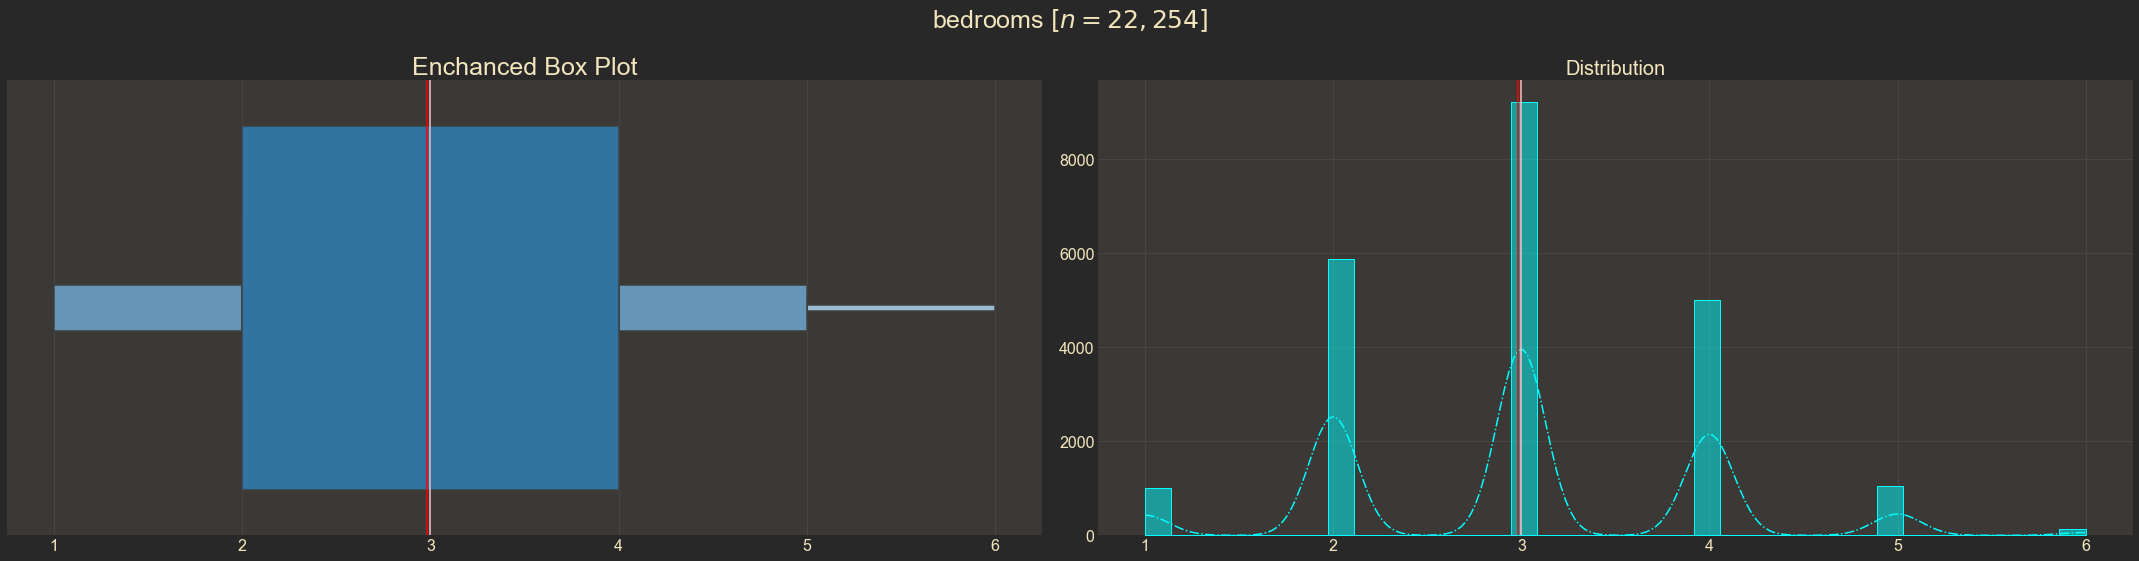

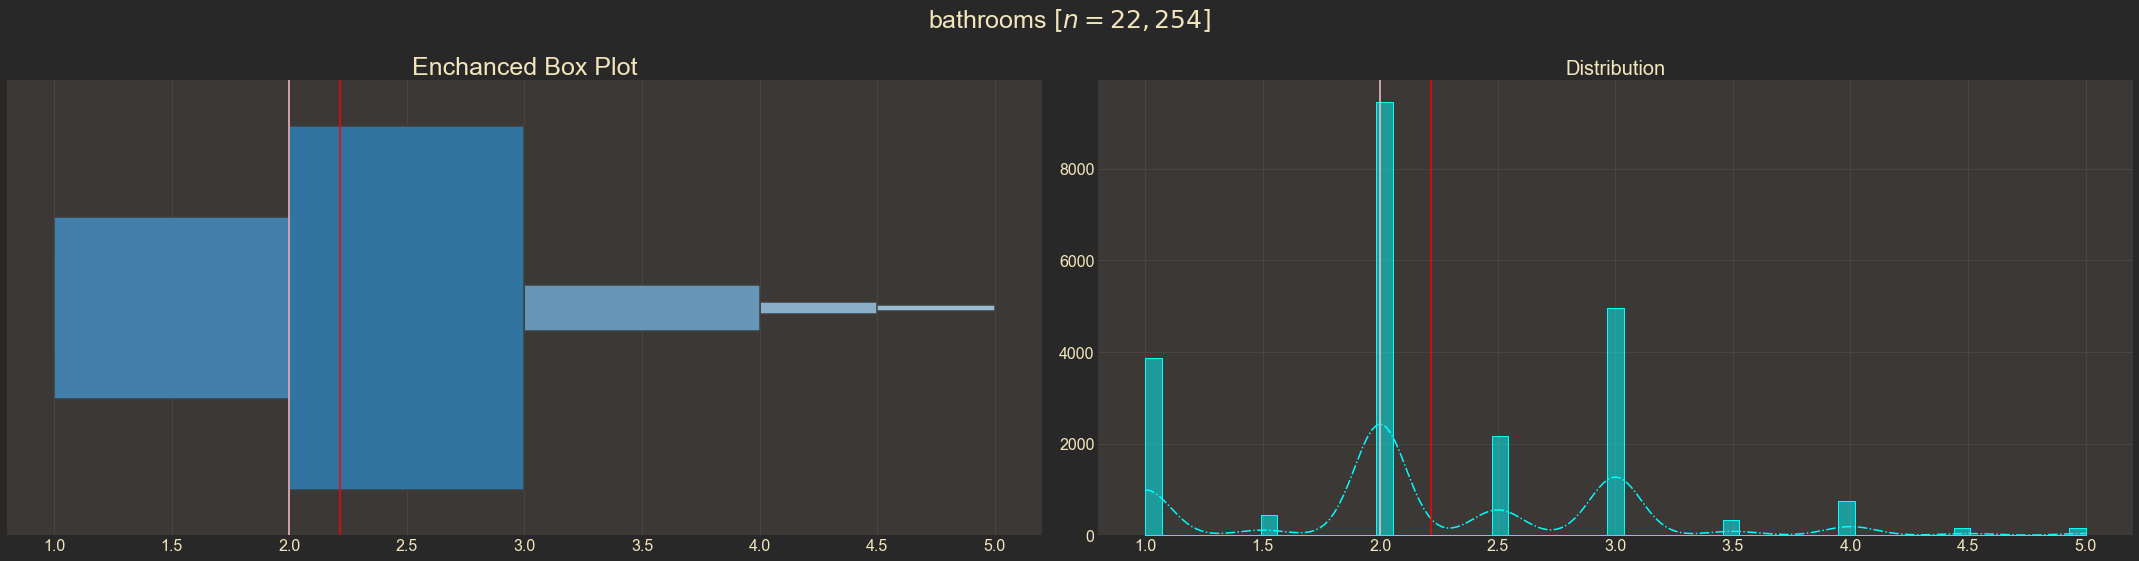

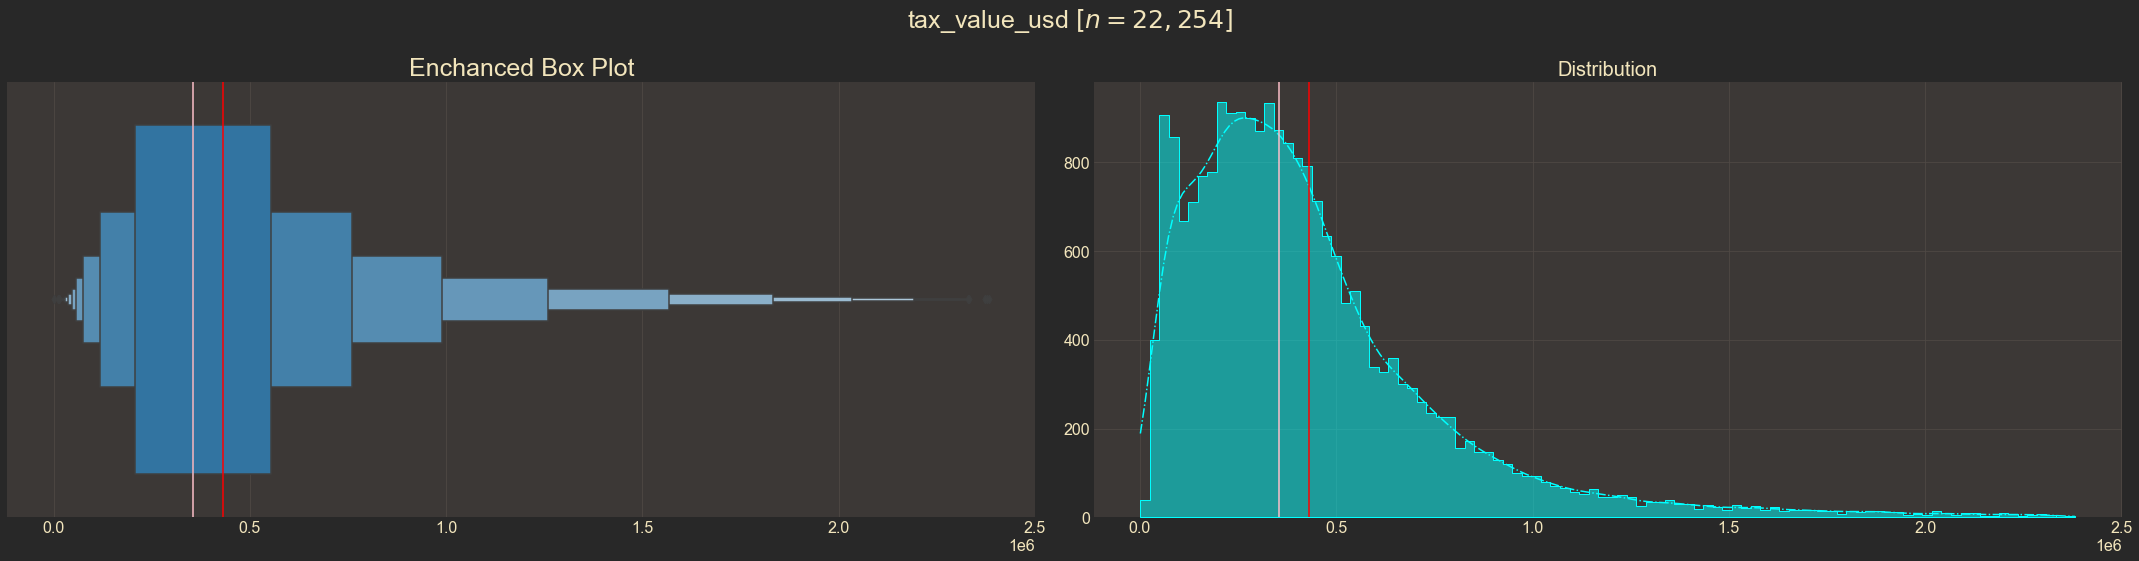

In [39]:
# plot each variable used in MVP
plot_univariate(df_mvp, 'bedrooms')
plot_univariate(df_mvp, 'bathrooms')
plot_univariate(df_mvp, 'square_feet')
plot_univariate(df_mvp, 'tax_value_usd')

**Interpretation**

Looking at our distributions, we can see that there is some right skew in all our variables except bedrooms, which is fairly normal. The red line signifies the variable mean, while the pink line denotes the median.

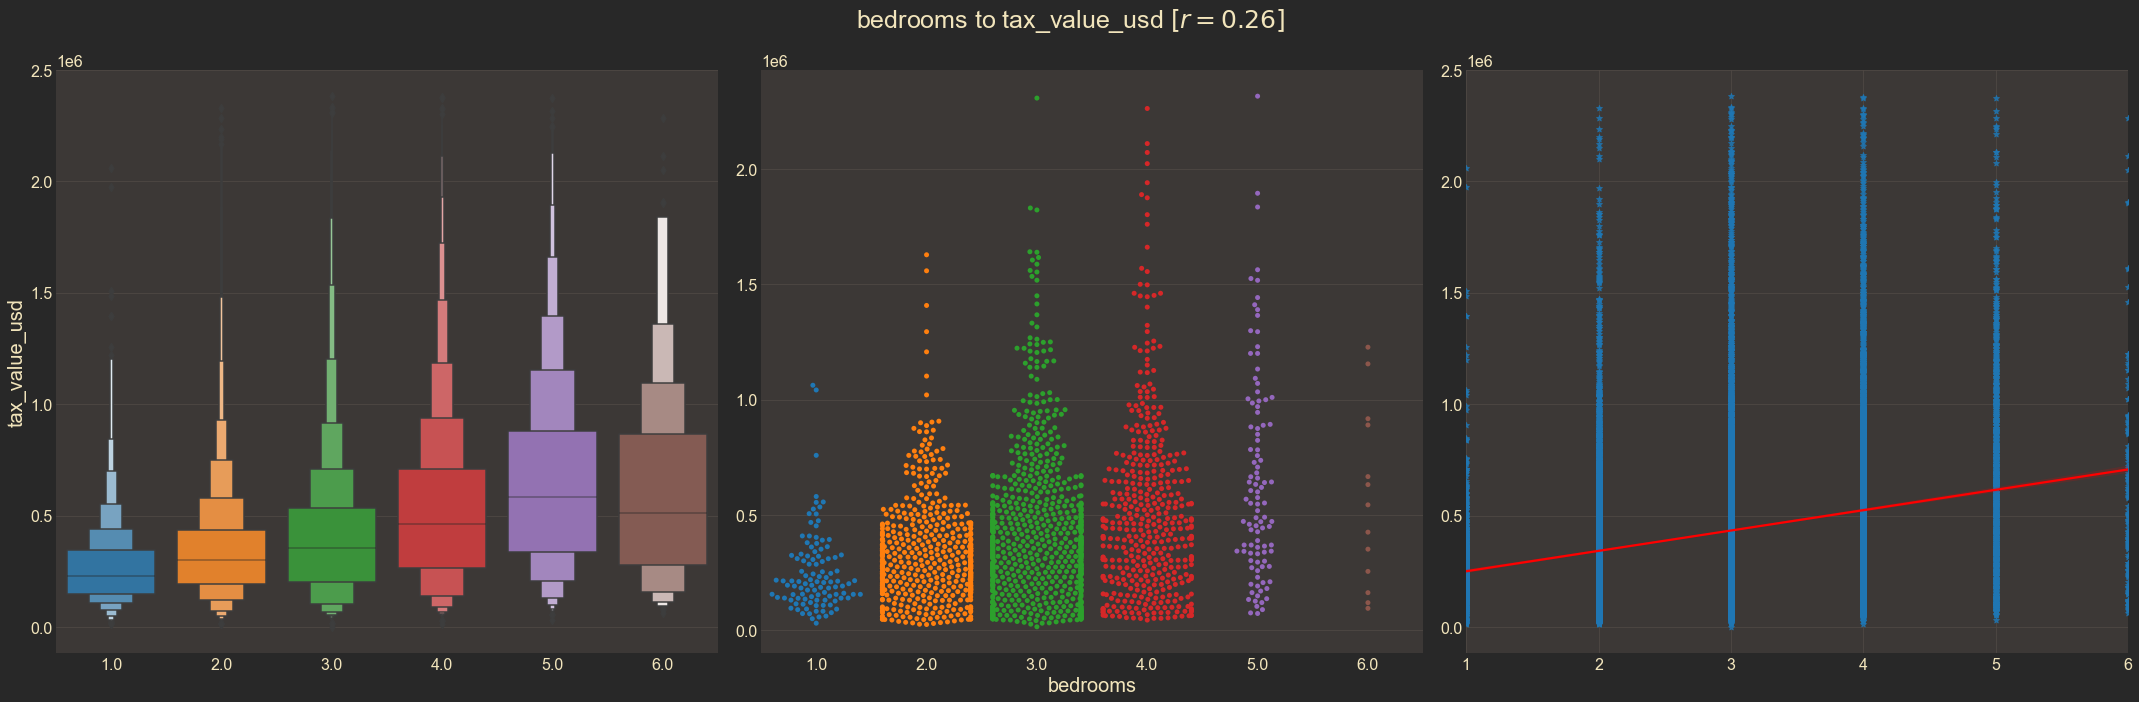

In [40]:
# visualize relationship of bedrooms to tax_value_usd
plot_discrete_to_continous(df_mvp, 'bedrooms', 'tax_value_usd')

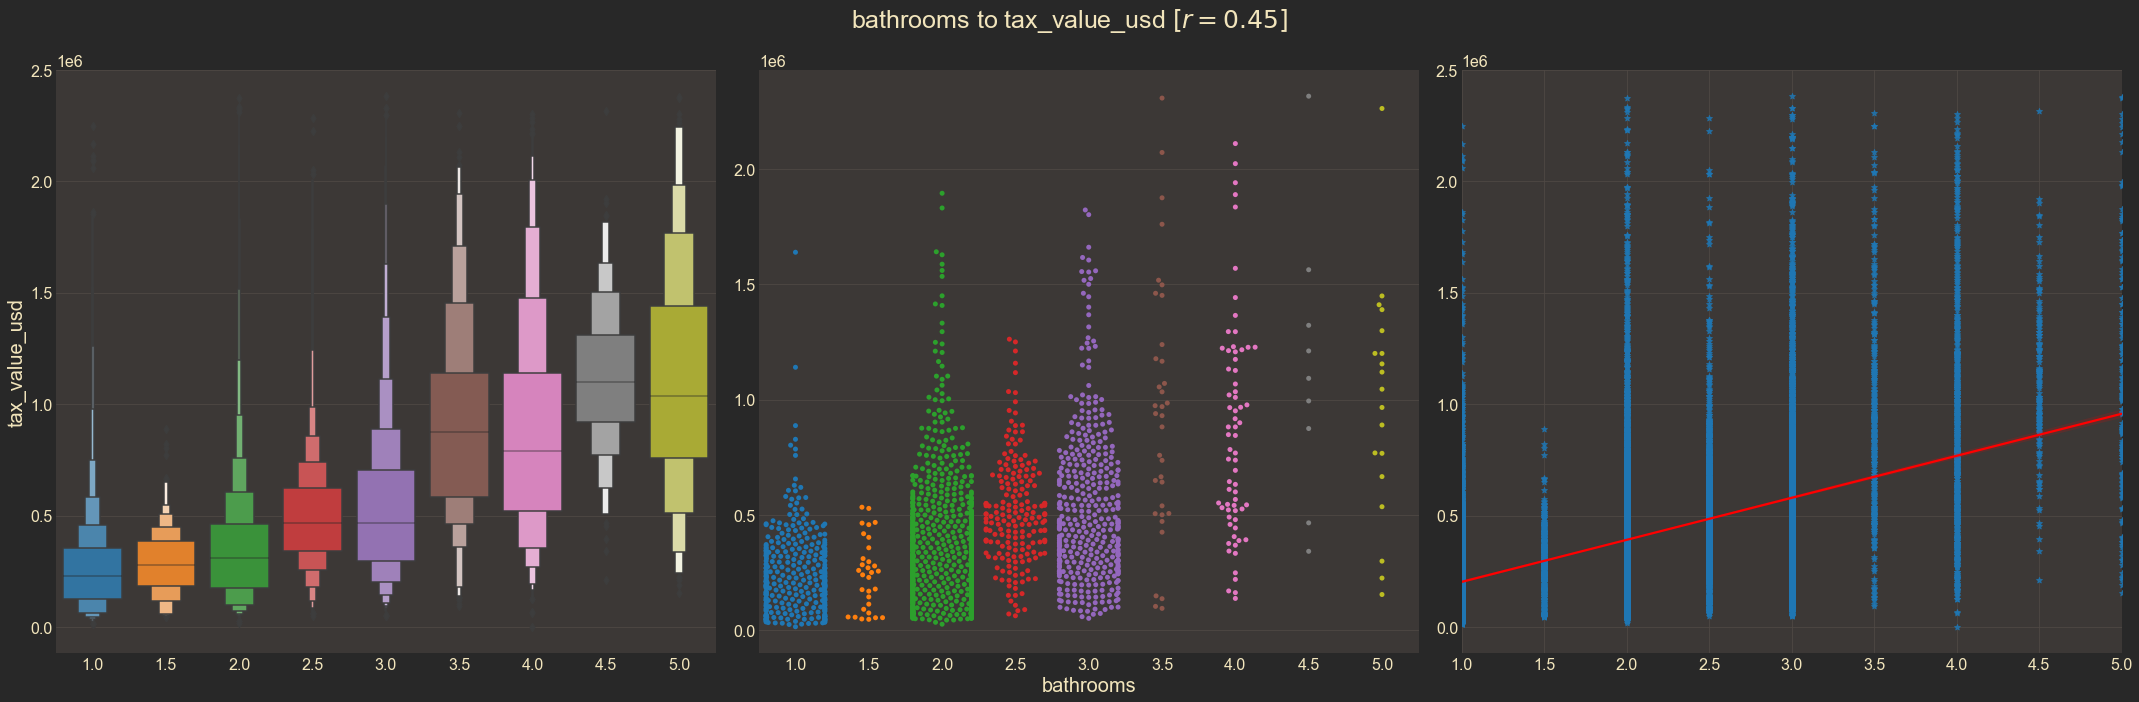

In [41]:
# visualized relationship of bathrooms to tax_value_usd
plot_discrete_to_continous(df_mvp, 'bathrooms', 'tax_value_usd')

**Takeaways**

There exists a moderate positive relationship between bathrooms and bedrooms to the properties' assessed tax values. The wide variations in `tax_value_usd` between properties with the same amount of rooms is likely the result of lot size and location of the property rather than the structure itself.

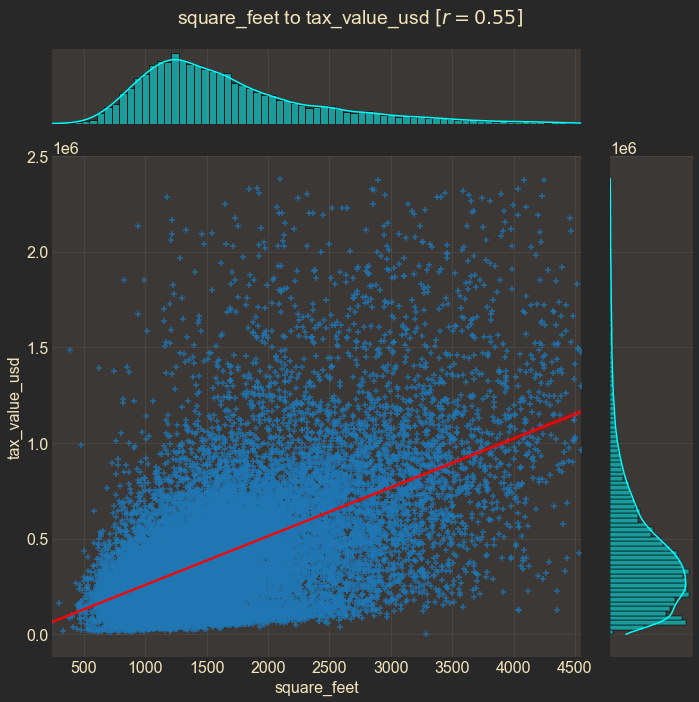

In [42]:
# plot jointplot of tax_value_usd to square_feet
plot_joint(df_mvp, 'square_feet', 'tax_value_usd')

**Impressions**

The strength of the positive relationship between `square_feet` and `tax_value_usd` is definitely stronger than the relationship of room type and numbers. Again we see a sizable range of values for similar structure sizes, which is likely the result of location and lot sizes.

#### Statistical Testing

**Hypotheses**:

- H$_0$: There is not a positive, linear correlation between the chosen variable and `tax_value_usd`.
- H$_a$: There is a positive, linear correlation between the chosen variable and `tax_value_usd`.

**Significance Level**:

- $\alpha$: 0.01

In [43]:
# each each variable other than the target, perform corr_test
for col in list(df_mvp.drop(columns='tax_value_usd')):
    corr_test(df_mvp, col, 'tax_value_usd', alpha=0.01, r_type='pearson')

   pearson r = 0.26
+--------------------+

        Due to p-value 0 being less than our significance level of 0.01, we must reject the null hypothesis 
        that there is not a linear correlation between "bedrooms" and "tax_value_usd."
        
   pearson r = 0.45
+--------------------+

        Due to p-value 0 being less than our significance level of 0.01, we must reject the null hypothesis 
        that there is not a linear correlation between "bathrooms" and "tax_value_usd."
        
   pearson r = 0.55
+--------------------+

        Due to p-value 0 being less than our significance level of 0.01, we must reject the null hypothesis 
        that there is not a linear correlation between "square_feet" and "tax_value_usd."
        


**Interpretation**

All of the MVP variables have passed the statistical tests, and we reject the null hypothesis for each one that there is no positive, linear correlation between them and `tax_value_usd`. Now that our variables are visualized and we have statistical data to back up those observations, we can move into the modeling phase.

[[return to top](#Predicting-Home-Values-with-Zillow)]

## Modeling
---
### Minimally Viable Product
#### Scale Data

In [44]:
# use mixmax function to scale data for model predicitons
X_train_scaled, X_validate_scaled, X_test_scaled = minmax(X_train_mvp, X_validate_mvp, X_test_mvp)

In [45]:
# look at first five rows of scaled train to compare to non-scaled train
X_train_scaled.head(5)

bedrooms  bathrooms  square_feet
property_id                                  
174360            0.4      0.375     0.382312
1322494           0.4      0.250     0.299907
2397357           0.2      0.125     0.257196
1850212           0.6      0.250     0.376509
2011586           0.2      0.250     0.197539

In [46]:
# compare to first five rows of non-scaled
X_train_mvp.head(5)

bedrooms  bathrooms  square_feet
property_id                                  
174360            3.0        2.5       1889.0
1322494           3.0        2.0       1534.0
2397357           2.0        1.5       1350.0
1850212           4.0        2.0       1864.0
2011586           2.0        2.0       1093.0

#### Feature Selections

As part of our MVP specifications, we will be using the three variables as features for our models, but let's see which features would be the top recommended.

In [47]:
# check SelectKBest recommended top feature
select_kbest(X_train_scaled, y_train_mvp)

['square_feet']

In [48]:
# check RFE recommended top feature
_ = select_rfe(X_train_scaled, y_train_mvp, rank=True)

  n=1 RFE Rankings
1      square_feet
2         bedrooms
3        bathrooms


Both SelectKBest and RFE recommended `square_feet` as the best model for predicting our `y_train`. This is just as exploration of our features, but all three will be used for predictions.

#### Establish Baseline

In [49]:
# establish a baseline using mean and median of tax_value_usd
baseline_mean = y_train_mvp.tax_value_usd.mean()
baseline_median = y_train_mvp.tax_value_usd.median()

In [50]:
# append baseline to all y DataFrames
y_train_mvp['baseline_mean'] = baseline_mean
y_train_mvp['baseline_median'] = baseline_median
y_validate_mvp['baseline_mean'] = baseline_mean
y_validate_mvp['baseline_median'] = baseline_median
y_test_mvp['baseline_mean'] = baseline_mean
y_test_mvp['baseline_median'] = baseline_median

In [51]:
# assign true values to variable
train_true = y_train_mvp.tax_value_usd
val_true = y_validate_mvp.tax_value_usd
test_true = y_test_mvp.tax_value_usd

In [52]:
# get baseline performance
rmse, r2 = get_metrics(train_true, y_train_mvp['baseline_mean'])

# create model metrics DataFrame
train_performance_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
train_performance_df = pd.DataFrame([train_performance_dict])

In [53]:
# get baseline median performance
rmse, r2 = get_metrics(train_true, y_train_mvp['baseline_median'])

# add more to model metrics DataFrame
train_performance_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
train_performance_df = train_performance_df.append([train_performance_dict], ignore_index=True)

#### Model Creation

##### LinearRegression

In [54]:
# create model object
lm = LinearRegression(normalize=True)

In [55]:
# obtain model predictions and performance metrics on training data
lm_predictions, train_performance_dict = train_model(X_train_scaled, train_true, lm, 'lm')

# assign predicitons to y DataFrame
y_train_mvp['lm_predictions'] = lm_predictions

# add more to model metrics DataFrame
train_performance_df = train_performance_df.append([train_performance_dict], ignore_index=True)

##### LassoLars

In [56]:
# create model object
lars = LassoLars(random_state=19)

In [57]:
# obtain model predictions and performance metrics on training data
lars_predictions, train_performance_dict = train_model(X_train_scaled, train_true, lars, 'lars')

# assign predicitons to y DataFrame
y_train_mvp['lars_predictions'] = lars_predictions

# add more to model metrics DataFrame
train_performance_df = train_performance_df.append([train_performance_dict], ignore_index=True)

##### TweedieRegressor

In [58]:
# create model object
glm = TweedieRegressor(power=1.0)

In [59]:
# obtain model predictions and performance metrics on training data
glm_predictions, train_performance_dict = train_model(X_train_scaled, train_true, glm, 'glm')

# assign predicitons to y DataFrame
y_train_mvp['glm_predictions'] = glm_predictions

# add more to model metrics DataFrame
train_performance_df = train_performance_df.append([train_performance_dict], ignore_index=True)

##### Polynomial Regression

In [60]:
# create polynomial object
pf = PolynomialFeatures()

# fit and transform to scaled train
X_train_deg2 = pf.fit_transform(X_train_mvp)

# transform scaled validate and test
X_validate_deg2 = pf.transform(X_validate_mvp)
X_test_deg2 = pf.transform(X_test_mvp)

In [61]:
# create model object
lm2 = LinearRegression(normalize=True)

In [62]:
# obtain model predictions and performance metrics on training data
lm2_predictions, train_performance_dict = train_model(X_train_deg2, train_true, lm2, 'lm2')

# assign predicitons to y DataFrame
y_train_mvp['lm2_predictions'] = lm2_predictions

# add final model to metrics DataFrame
train_performance_df = train_performance_df.append([train_performance_dict], ignore_index=True).rename(columns={'RMSE':'RMSE Train', 'R^2':'R^2 Train'})

**Overall Training Performance**

In [63]:
# display performance DataFrame for train predictions
train_performance_df.sort_values('RMSE Train')

model     RMSE Train  R^2 Train
5              lm2  273235.205168   0.334958
2               lm  274631.194090   0.328145
3             lars  274631.461051   0.328144
4              glm  276786.676563   0.317557
0    baseline_mean  335051.870797   0.000000
1  baseline_median  343586.488022   0.000000

- `lm2` performed slightly better than `lm` on the in-sample dataset

#### Model Evaluation
##### Out-of-Sample Testing

In [64]:
# get baseline performance
rmse, r2 = get_metrics(val_true, y_validate_mvp['baseline_mean'])

# create model metrics DataFrame
validate_performance_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
validate_performance_df = pd.DataFrame([validate_performance_dict])

In [65]:
# get baseline median performance
rmse, r2 = get_metrics(val_true, y_validate_mvp['baseline_median'])

# add more to model metrics DataFrame
validate_performance_dict = {'model':'baseline_median', 'RMSE':rmse, 'R^2':r2}
validate_performance_df = validate_performance_df.append([validate_performance_dict], ignore_index=True)

In [66]:
# obtain model predictions and performance metrics on validate data
lm_predictions, validate_performance_dict = model_testing(X_validate_scaled, val_true, lm, 'lm')

# assign predicitons to y DataFrame
y_validate_mvp['lm_predictions'] = lm_predictions

# add more to model metrics DataFrame
validate_performance_df = validate_performance_df.append([validate_performance_dict], ignore_index=True)

In [67]:
# obtain model predictions and performance metrics on validate data
lars_predictions, validate_performance_dict = model_testing(X_validate_scaled, val_true, lars, 'lars')

# assign predicitons to y DataFrame
y_validate_mvp['lars_predictions'] = lars_predictions

# add more to model metrics DataFrame
validate_performance_df = validate_performance_df.append([validate_performance_dict], ignore_index=True)

In [68]:
# obtain model predictions and performance metrics on validate data
glm_predictions, validate_performance_dict = model_testing(X_validate_scaled, val_true, glm, 'glm')

# assign predicitons to y DataFrame
y_validate_mvp['glm_predictions'] = glm_predictions

# add more to model metrics DataFrame
validate_performance_df = validate_performance_df.append([validate_performance_dict], ignore_index=True)

In [69]:
# obtain model predictions and performance metrics on validate data
lm2_predictions, validate_performance_dict = model_testing(X_validate_deg2, val_true, lm2, 'lm2')

# assign predicitons to y DataFrame
y_validate_mvp['lm2_predictions'] = lm2_predictions

# add more to model metrics DataFrame
validate_performance_df = validate_performance_df.append([validate_performance_dict], ignore_index=True).rename(columns={'RMSE':'RMSE Val', 'R^2':'R^2 Val'})

In [70]:
# display performance DataFrame for train and validate predictions
metrics_df = pd.concat((train_performance_df, validate_performance_df[['RMSE Val', 'R^2 Val']]), axis=1)

In [71]:
metrics_df.sort_values('RMSE Val')

model     RMSE Train  R^2 Train       RMSE Val   R^2 Val
5              lm2  273235.205168   0.334958  276161.564170  0.331213
2               lm  274631.194090   0.328145  277100.312833  0.326671
3             lars  274631.461051   0.328144  277100.522043  0.326670
4              glm  276786.676563   0.317557  279303.159548  0.315936
0    baseline_mean  335051.870797   0.000000  337701.446242  0.000000
1  baseline_median  343586.488022   0.000000  346831.837139  0.000000

- `lm2` again slightly out performed `lm` on the out-of-sample dataset

##### Visualizing Out-of-Sample Performance

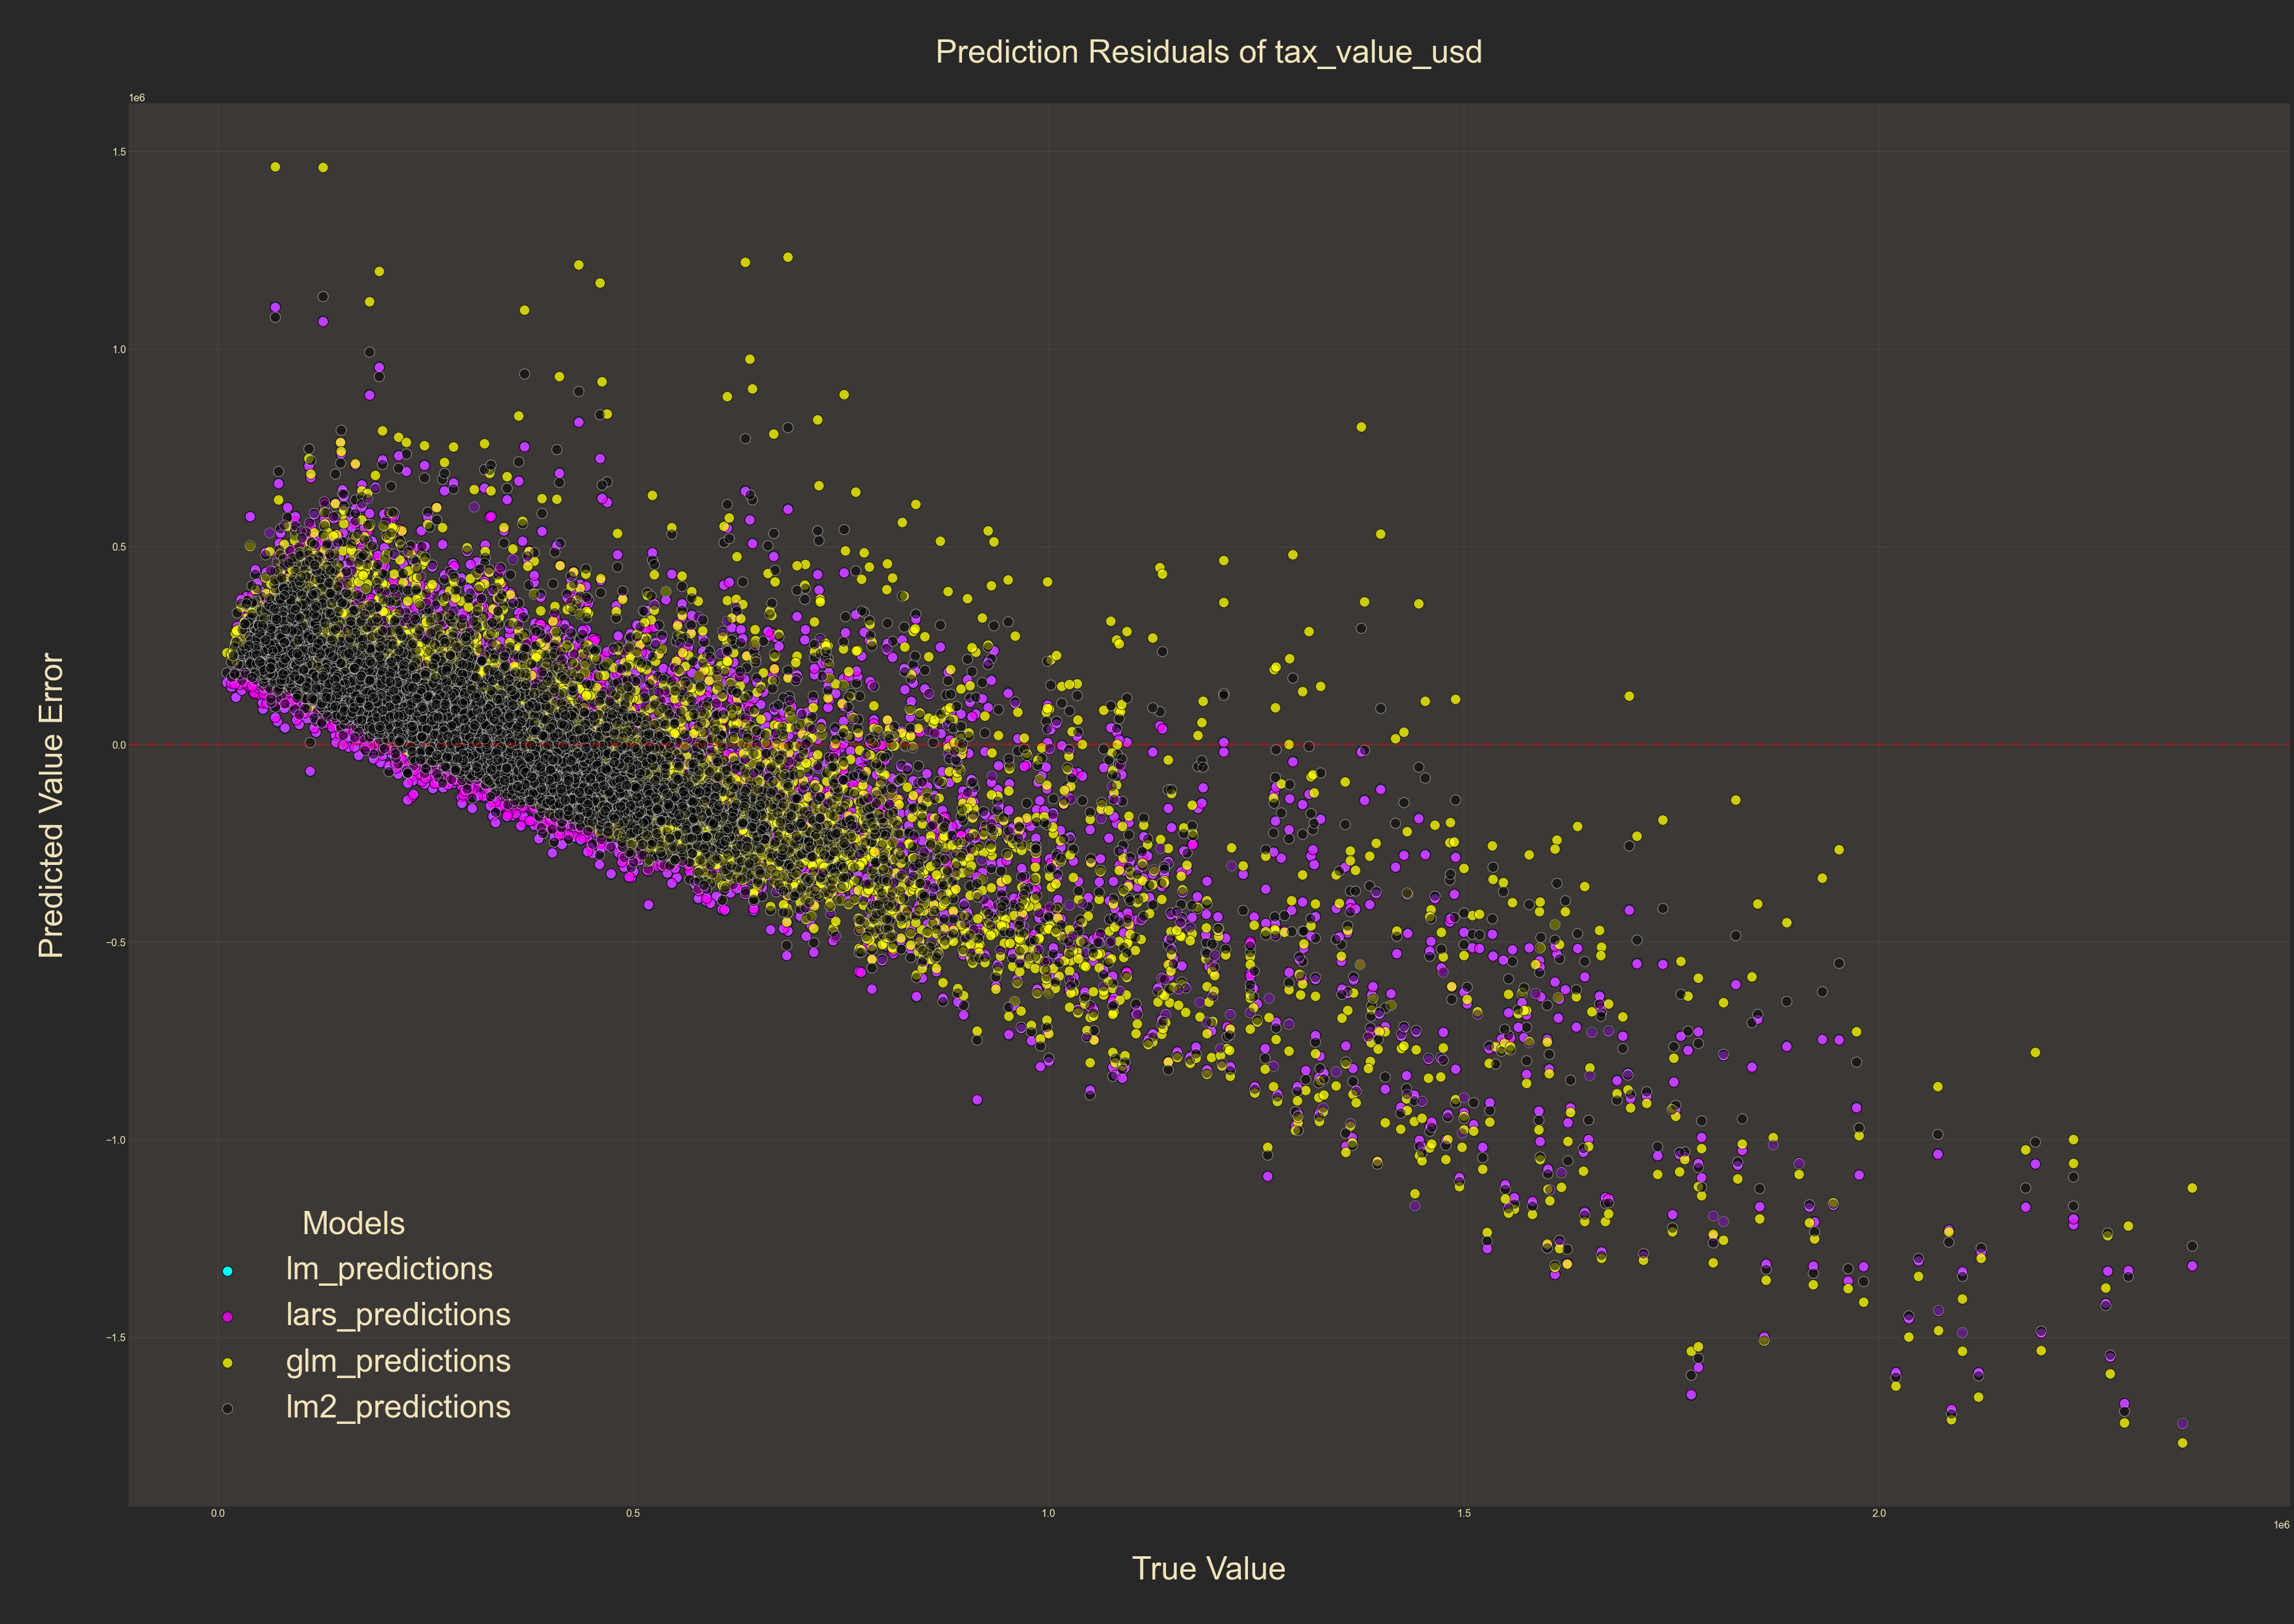

In [72]:
# set DataFrame of model predictions to pass into plot_residuals function
y_preds = y_validate_mvp[['lm_predictions', 'lars_predictions', 'glm_predictions', 'lm2_predictions']]
plot_residuals(val_true, y_preds)

**Visual Takeaway**

The numbers for model predictions showed that `lm2` performed slightly higher than the rest of the models, and in the graphics we can see that represented well. At the lower true `tax_value_usd`, the predictions are all much tighter than the other models, and the residuals lay closer to the zero line. As the true value in creases, all the models consistently under estimate the value. This is likely the result of aspects of the property not being considered, especially location and lot size.

In future models, it would be best to take those into consideration when predicting value, perhaps we would see better precision in those high true values.

#### Model Test

Now that we have our best performing MVP model, we can test it on our `test` dataset. We will use our 2nd degree polynomial model on this set to see how well we perform.

In [73]:
# get baseline performance
rmse, r2 = get_metrics(test_true, y_test_mvp['baseline_mean'])

# create model metrics DataFrame
test_performance_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
test_performance_df = pd.DataFrame([test_performance_dict])

In [74]:
# get baseline performance
rmse, r2 = get_metrics(test_true, y_test_mvp['baseline_mean'])

# create model metrics DataFrame
validate_performance_dict = {'model':'baseline_mean', 'RMSE':rmse, 'R^2':r2}
test_performance_df = test_performance_df.append([test_performance_dict], ignore_index=True)

In [75]:
# obtain model predictions and performance metrics on test data
lm2_predictions, test_performance_dict = model_testing(X_test_deg2, test_true, lm2, 'lm2')

# assign predicitons to y DataFrame
y_test_mvp['lm2_predictions'] = lm2_predictions

# add more to model metrics DataFrame
test_performance_df = test_performance_df.append([test_performance_dict], ignore_index=True).rename(columns={'RMSE':'RMSE Test', 'R^2':'R^2 Test'})

In [76]:
test_performance_df.sort_values('RMSE Test')

model      RMSE Test      R^2 Test
2            lm2  271768.120027  3.283242e-01
0  baseline_mean  331608.344543  1.110223e-16
1  baseline_mean  331608.344543  1.110223e-16

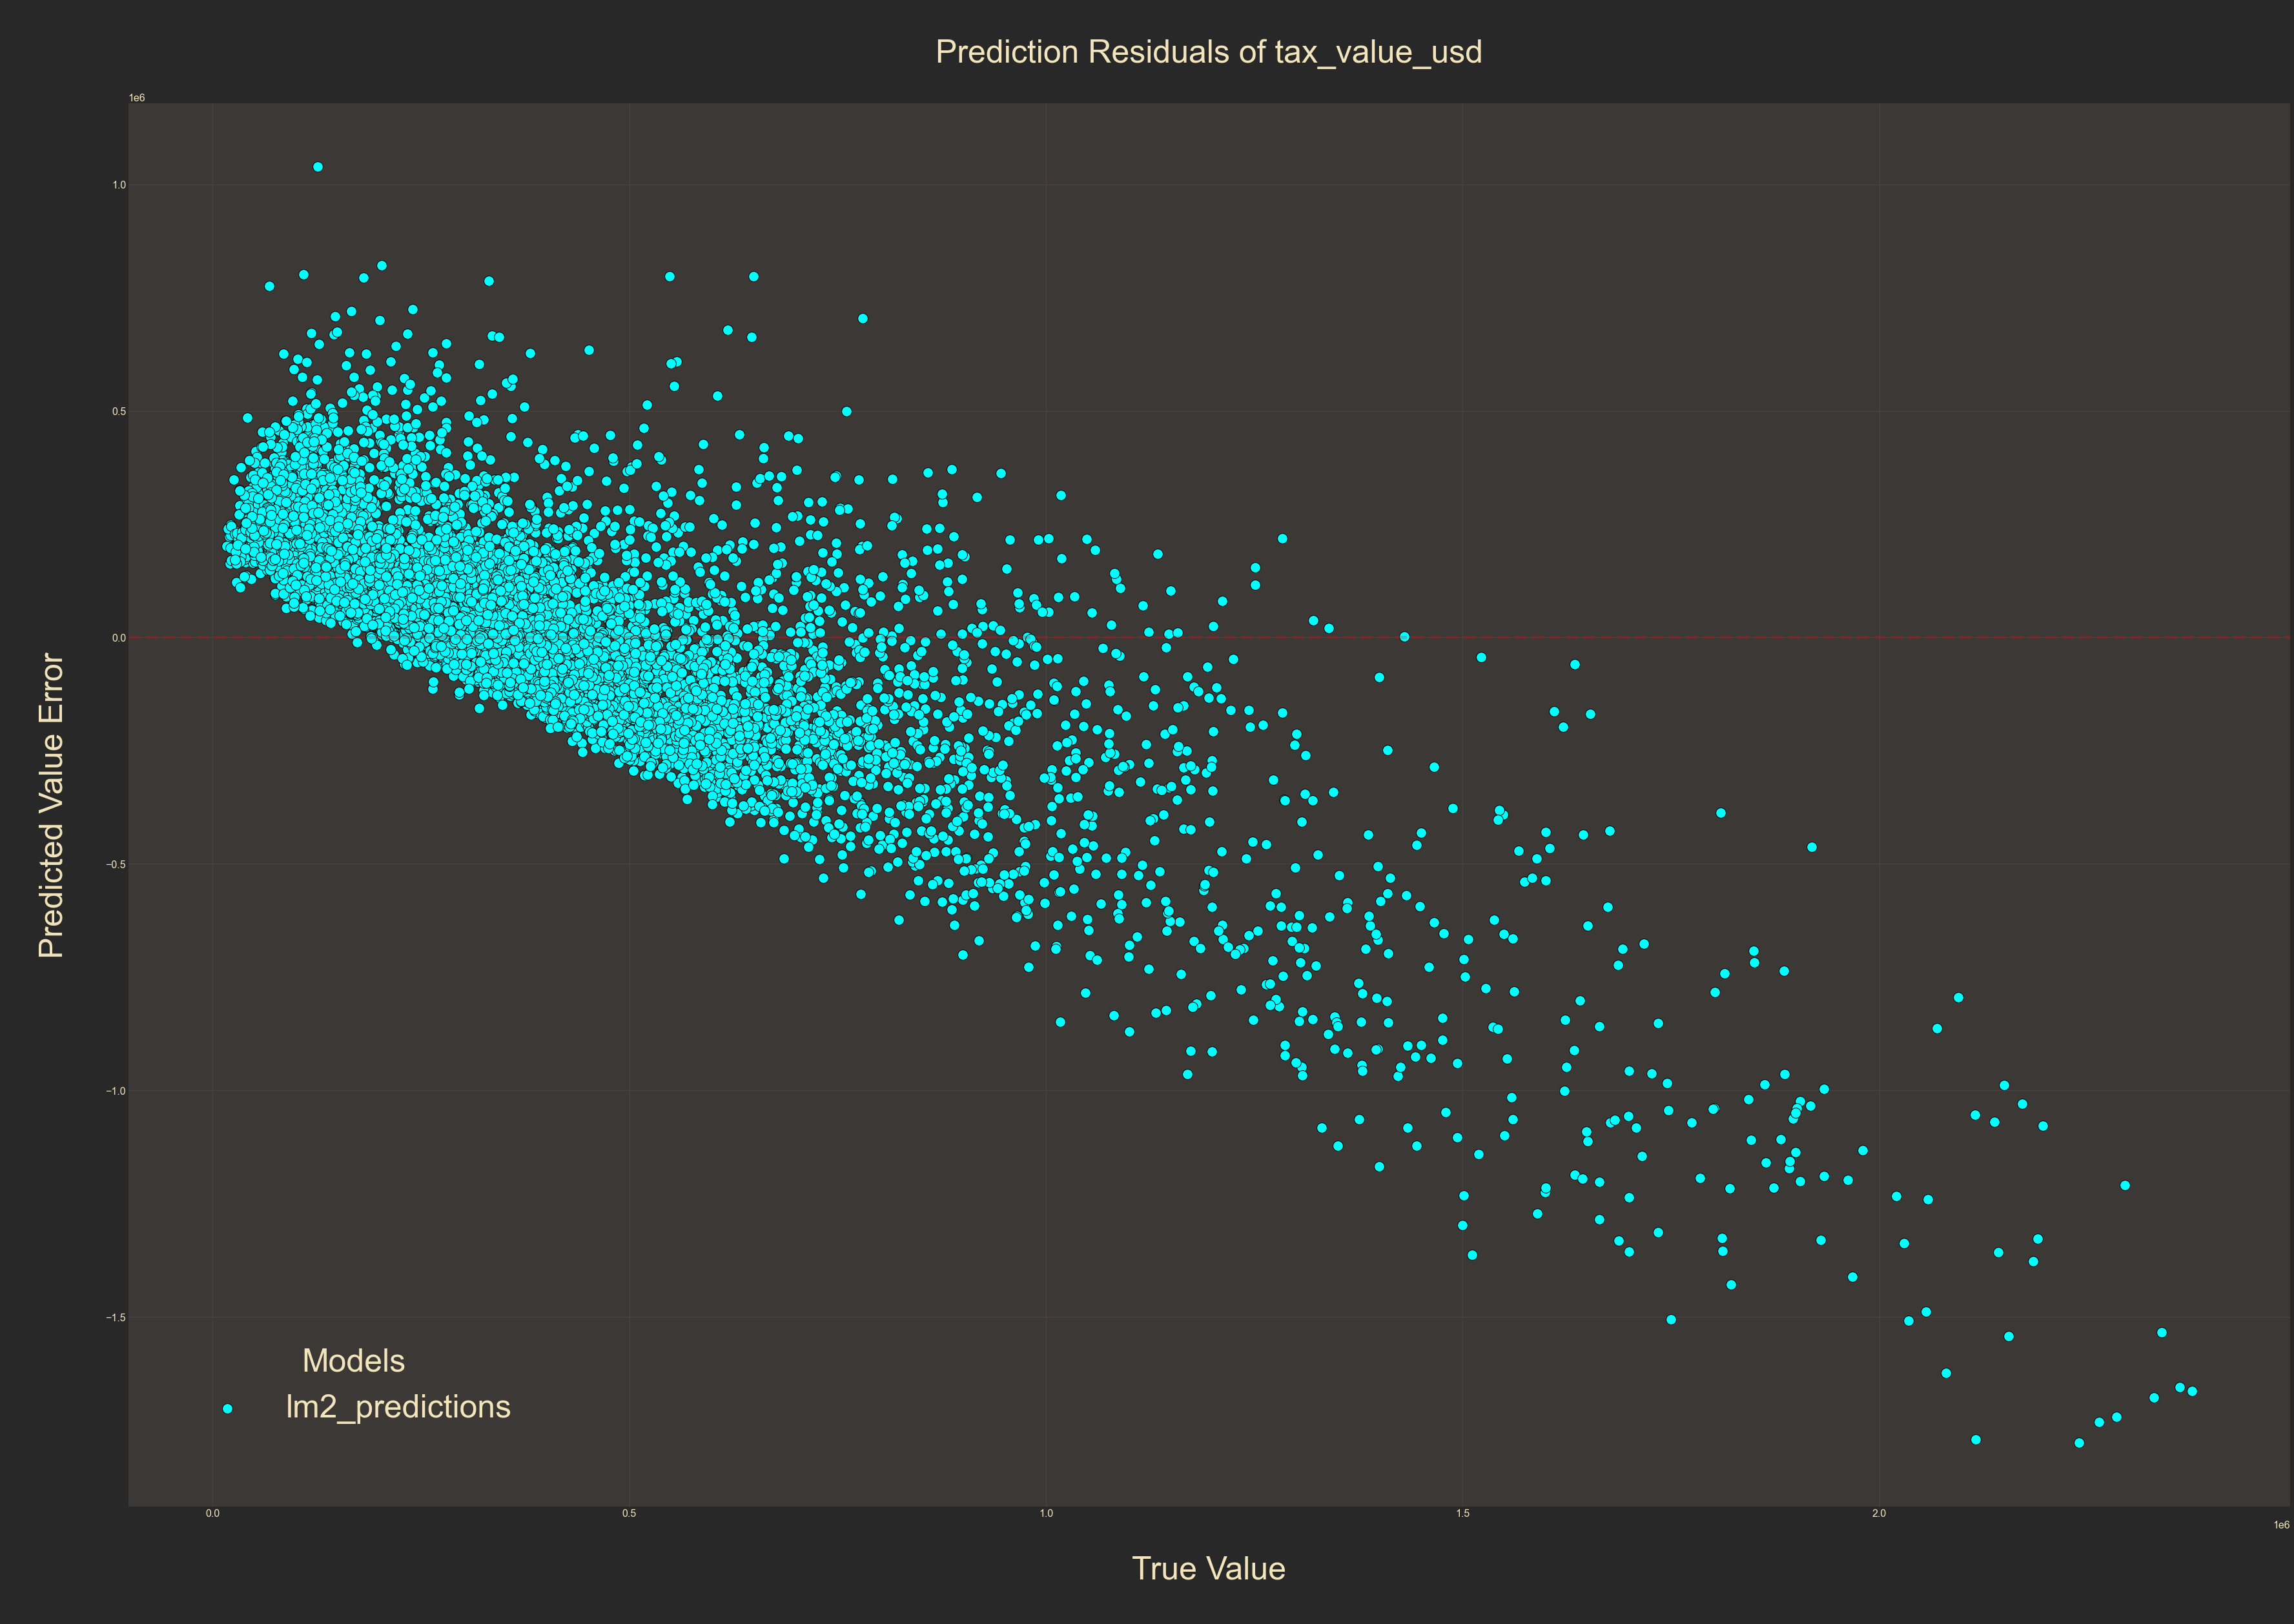

In [77]:
# set DataFrame of model predictions to pass into plot_residuals function
y_preds = y_test_mvp[['lm2_predictions']]
plot_residuals(test_true, y_preds)

**Visual Takeaways**

We again see a similar plotting here for the `test` residuals with `lm2` predictions. Higher true values are under predicted. But we have a slightly lower RMSE on the `test` than the `validate` and `train` datasets, but not significantly. Overall, the model performance as held up well through creation and testing.

[[return to top](#Predicting-Home-Values-with-Zillow)]

## Estimating Tax Rates
---

With the data we prepared prior to exploration, we can estimate our tax rates as requested for our deliverables. This data will not be used in modeling as it will be constructed using our target variable.

**Tax Rate Distribution**

Here we ca obtain the tax rates for each individual property and output a plot of the distribution of tax rates per county. We will output this to a CSV file for future documentation.

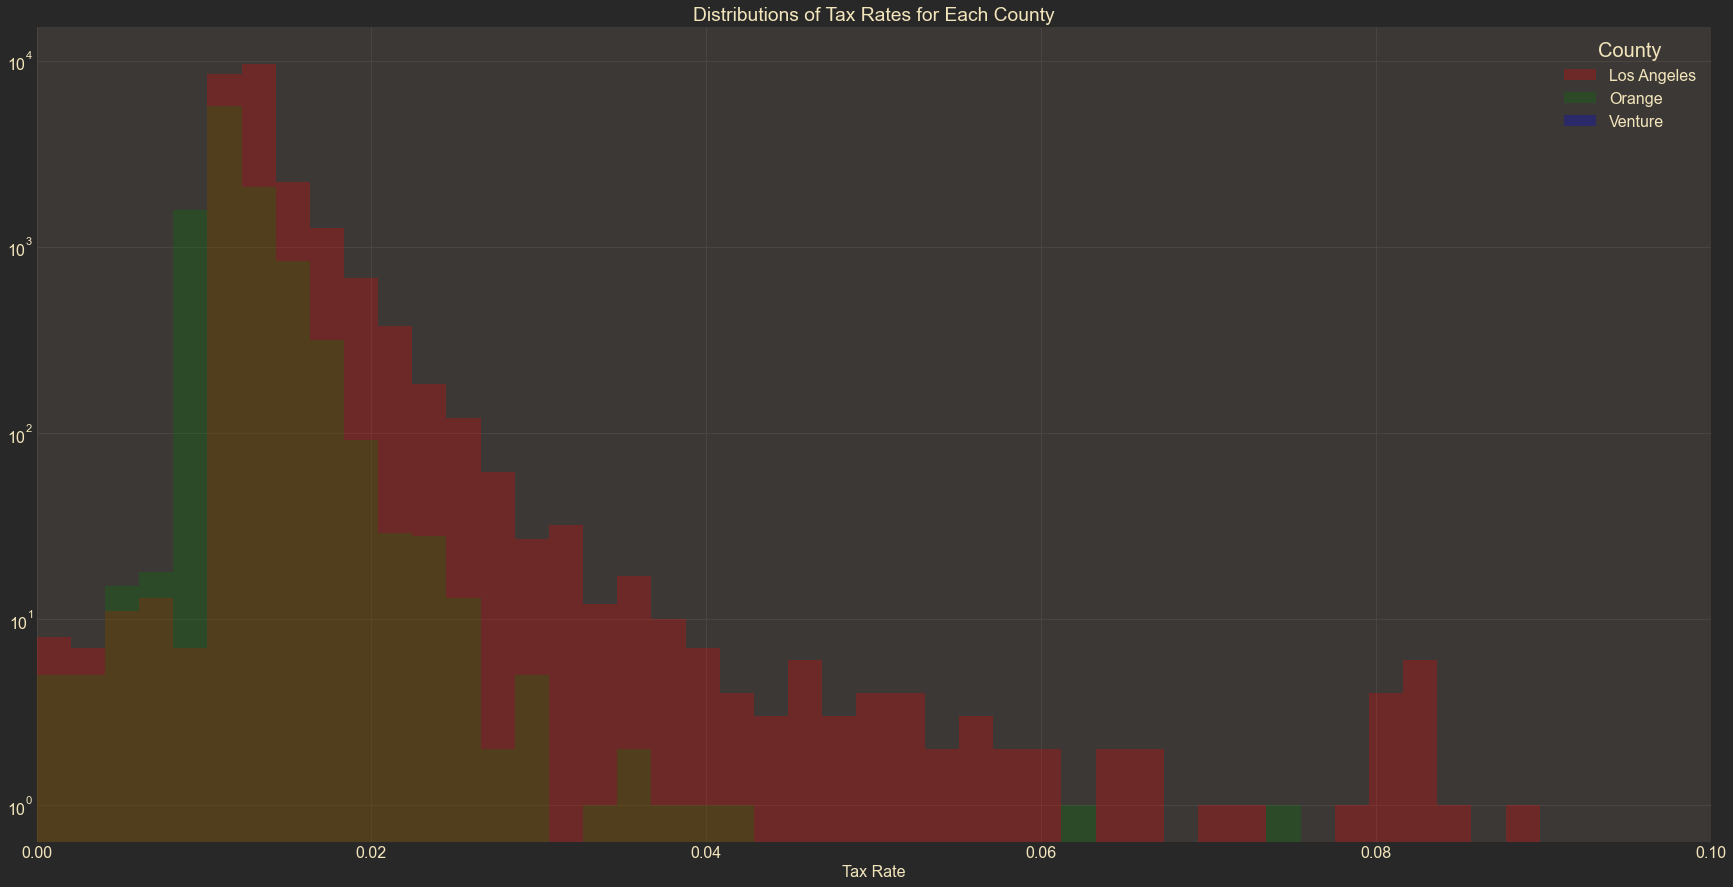

county  tax_amount_usd  tax_value_usd  tax_rate
property_id                                                      
1076450      Los Angeles         5823.80       389491.0  0.014952
1378865      Los Angeles         1918.09       130845.0  0.014659
1378732      Los Angeles          690.45        47792.0  0.014447

In [78]:
# run function to get DataFrame of individual tax rates and plot distribution
df_taxes = get_tax_rates()
# output DataFrame to CSV
df_taxes.to_csv('tax_rates.csv')
# output first three rows of DataFrame
df_taxes.head(3)

**County Tax Rates**

We will use the function `get_tax_rate` from `prepare.py`. For each county, each property's tax rate will be calculated by using its `tax_amount_usd` $(x)$ and dividing it by `tax_value_usd` $(y)$. These will be summed for each county, and that sum will be divided by the number of observations $(n)$ per county to obtain an average `tax_rate` $(t)$ for all the observations in the county.
<br><br>
<span style='font-size:1.5em;'>
$$t = \frac{\Sigma (\frac{x}{y})_n}{n}$$
</span>

In [79]:
# run function to get DataFrame of county tax rates
df_county_tax = get_tax_rates_county()
# output DataFrame to CSV
df_county_tax.to_csv('tax_rates_county.csv')
# output first three rows of DataFrame
df_county_tax.head(3)

avg_tax_amount_usd  avg_tax_value_usd  tax_rate
county_name                                                 
Los Angeles         5159.400696      406432.952365  0.013783
Orange              5631.816593      483927.326698  0.012051
Ventura             5117.075751      437588.390903  0.011954

**Estimated Tax Rates**<br>

Using our available data, we can calculate an average tax rate for counties using `tax_amount_usd` and `tax_value_usd`.

- LA County: $\approx1.38\%$ of assessed property value
- Orange County: $\approx1.21\%$ of assessed property value
- Ventura County: $\approx1.2\%$ of assessed property value

[[return to top](#Predicting-Home-Values-with-Zillow)]

## Summary
---

From our initial data acquisition of $38,412$ observations, we obtained all the data necessary for our minimally viable product to predict home values during the 2017 "hot months." From the remaining $38,312$ we split it into $60\%$ `train`, $20\%$ `validate`, and $20\%$ `test` datasets and preparing it in a manner that made it accessible to visually representing through plots and placing into a machine learning model to predict home values using `bedrooms`, `bathrooms`, and `square_feet` as our features. With this data, we created a 2nd Degree Polynomial Regression model that out performed the rest of its created siblings in on in-sample and out-of-sample datasets. This model was then tested on the `test` dataset with $\$271,768.12$ for the Root Mean Squared Error. This model out performed both mean and median being used as a baseline.

**Key Takeaways**

- Much or all of the data obtained in the acquire phase contained null-values
- We saw moderate positive correlation between all our features and our target in plotting and statistical testing
- RFE and KBest feature selection both recommended `square_feet` as our best predictor.
- Second degree polynomial regression model, `lm2`, out performed the standard linear regression model, `lm`, by only $0.34\%$
- Due to our models not taking location and property lot size into consideration, they consistently under performed at higher true values

**Next Phase**

With our minimally viable product completed, the next steps will involve utilizing more of the available data as features in further predictions. With enough time, we can demonstrate whether or not lot size and location will prove beneficial to more accurately predicting values.

[[return to top](#Predicting-Home-Values-with-Zillow)]